<a href="https://colab.research.google.com/github/UoR-Vision/VisualDota/blob/main/src/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

## Install Required Packages

In [ ]:
!pip install importlib ultralytics torch torchvision shapely gradio gradio_client

***
<a id="import"></a>
## Import libraries

To import the required libraries for whole project.

In [2]:
# import the build-in required libraries
from collections import Counter, defaultdict
import os
import time
import logging

# import the third-part required libraries
import cv2
import importlib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
import ultralytics
from zipfile import ZipFile
from ultralytics.utils import SETTINGS

os.environ['GLOG_minloglevel'] = '3'
logging.disable(logging.CRITICAL)

# 修改全局设置
SETTINGS.update({
    "datasets_dir": "",
})


# check the versions of third-part libraries
print(f'matplotlib: {matplotlib.__version__}, numpy: {np.__version__}, pandas: {pd.__version__}')
print(f'torch: {torch.__version__}, torchvision: {torchvision.__version__}, ultralytics: {ultralytics.__version__}')

# check environment
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'device: {device}')

matplotlib: 3.10.0, numpy: 2.0.2, pandas: 2.2.2
torch: 2.8.0+cu126, torchvision: 0.23.0+cu126, ultralytics: 8.3.202
device: cuda


***
<a id="colab"></a>
## Adapting to the Colab Operating Environment

In Colab environment, it is neccessary to download the whole project from Github.

In [3]:
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False


if is_colab():
    print('Running in Google Colab and using Google Drive.')
    !git clone "https://github.com/WeijieCui/MARS.git" -b main
    %cd MARS/src
    used_drive = bool(input("Do you want to use Google Drive? If so, "
    "please make sure you have prepared the dataset and models appropriately.\n"
    "Use Google Drive: Y/N: ").lower() == 'y')
    if used_drive:
      try:
          from google.colab import drive
          drive.mount('/content/drive')
          DATASET_ROOT_DIR = '/content/drive/MyDrive/VisualDota/DOTA'
          MODEL_ROOT_DIR = '/content/drive/MyDrive/VisualDota/models'
      except ImportError as e:
          print(f'failed to import google package: {e.msg}')
          DATASET_ROOT_DIR = './data'
          MODEL_ROOT_DIR = '../models'
    else:
      print('Running locally.')
      DATASET_ROOT_DIR = '../data'
      MODEL_ROOT_DIR = '../models'

else:
    print('Not running in Colab.')
    DATASET_ROOT_DIR = '../data'
    MODEL_ROOT_DIR = '../models'

Running in Google Colab and using Google Drive.
Cloning into 'MARS-Final'...
fatal: could not read Username for 'https://github.com': No such device or address
[Errno 2] No such file or directory: 'MARS-Final/src'
/content
Do you want to use Google Drive? If so, please make sure you have prepared the dataset and models appropriately.
Use Google Drive: Y/N: Y
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_image_dir = os.path.join(DATASET_ROOT_DIR, 'train', 'images')
train_label_dir = os.path.join(DATASET_ROOT_DIR, 'train', 'labelTxt')

***
<a id="hotload"></a>
## Hot Loading .py File

Here is to import custom .py file. It can be hot-loaded, just re-run the following cell.

Documentation comments are provided for each public function. To check the comments please use the help() function.

In [5]:
try:
    import data_validation
    import detector
    import agent
    import rl_model  # import data loader for data training
except ModuleNotFoundError as e:
    print(f'[ERROR] fail to import a custom module at path: {os.path.abspath(".")}, msg: {e}.')
except Exception as e:
    print(f'[ERROR] fail to read module at path: {os.path.abspath(".")}, msg: {e}')
else:
    # Hot loading python files
    importlib.reload(detector)
    importlib.reload(data_validation)
    importlib.reload(agent)
    importlib.reload(rl_model)

[ERROR] fail to import a custom module at path: /content, msg: No module named 'data_validation'.


# 2 Exploratory data analysis

## 2.1 Object Category Distribution

In [6]:
category_counts = Counter()

for file_name in os.listdir(train_label_dir):
    if file_name.endswith('.txt'):
        with open(os.path.join(train_label_dir, file_name)) as file:
            for line in file:
                try:
                    parts = line.strip().split()
                    if len(parts) >= 10:
                        category = parts[8].strip()
                        category_counts[category] += 1
                except Exception as e:
                    print(f"[ERROR] {file_name}: {e}")

# Convert to DataFrame
df_counts = pd.DataFrame(category_counts.items(), columns=["Category", "Count"])
df_counts = df_counts.sort_values(by="Count", ascending=False)

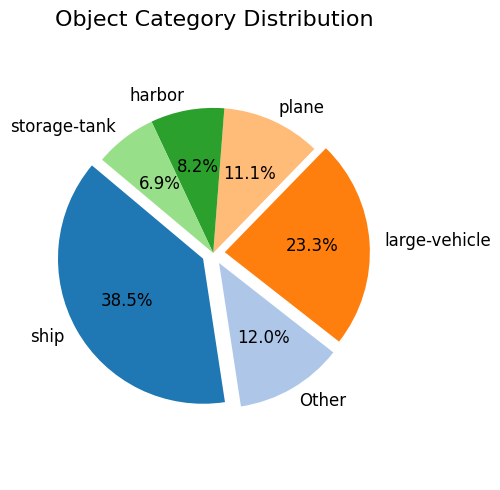

In [7]:
# Parameters
top_n = 6  # how many categories to show individually
colors = plt.cm.tab20.colors  # colorful palette

# Group small categories as 'Other'
df_counts_top = df_counts.head(top_n).copy()
other = df_counts.iloc[top_n:]["Count"].sum()
df_counts_top.loc[len(df_counts_top)] = ["Other", other]

# Create labels and data
labels = df_counts_top["Category"]
sizes = df_counts_top["Count"]

# Explode top 3 slightly
explode = [0.08 if i < 3 else 0 for i in range(len(sizes))]

# Plot
plt.figure(figsize=(5, 5))
plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=140,
    explode=explode,
    colors=colors[:len(sizes)],
    textprops={'fontsize': 12}
)
plt.title("Object Category Distribution", fontsize=16)
plt.axis("equal")
plt.tight_layout()
plt.show()

In [8]:
# Initialize counters
category_total = defaultdict(int)
category_difficult = defaultdict(int)

# Parse the zip
for file_name in os.listdir(train_label_dir):
    if file_name.endswith('.txt'):
        with open(os.path.join(train_label_dir, file_name)) as file:
            for line in file:
                try:
                    parts = line.strip().split()
                    if len(parts) >= 10:
                        category = parts[8].strip()
                        difficult = parts[-1].strip()
                        category_total[category] += 1
                        if difficult == '1':
                            category_difficult[category] += 1
                except Exception as e:
                    print(f"[ERROR] {file_name}: {e}")

In [9]:
# Combine into DataFrame
df_difficulty = pd.DataFrame({
    'Category': category_total.keys(),
    'Total': [category_total[c] for c in category_total],
    'Difficult': [category_difficult.get(c, 0) for c in category_total]
})

# Add % column
df_difficulty['Difficult %'] = (df_difficulty['Difficult'] / df_difficulty['Total']) * 100

# Sort by descending % of difficulty
df_difficulty = df_difficulty.sort_values(by='Difficult %', ascending=False)
df_difficulty.reset_index(drop=True, inplace=True)
df_difficulty.head()

,Category,Total,Difficult,Difficult %
0,soccer-ball-field,326,120,36.809816
1,storage-tank,5029,1005,19.984092
2,ground-track-field,325,36,11.076923
3,small-vehicle,26126,2646,10.127842
4,basketball-court,515,52,10.097087


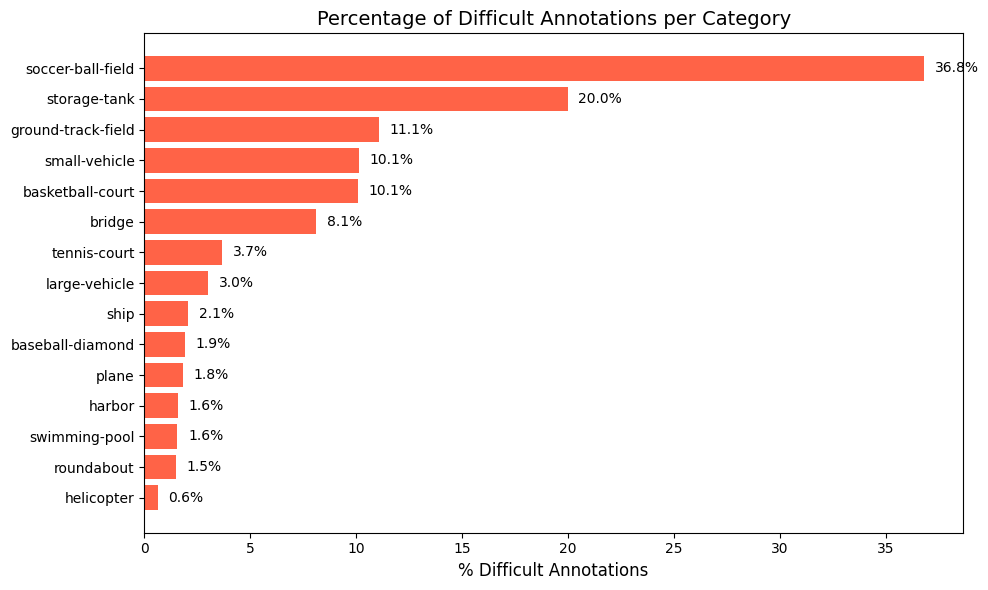

In [10]:
# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(df_difficulty['Category'], df_difficulty['Difficult %'], color='tomato')
plt.xlabel('% Difficult Annotations', fontsize=12)
plt.title('Percentage of Difficult Annotations per Category', fontsize=14)

# Add text labels to bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height() / 2,
             f'{width:.1f}%', va='center', fontsize=10)

plt.gca().invert_yaxis()  # highest % on top
plt.tight_layout()
plt.show()

## 2.3 Object Bounding Box Sizes Per Category

In [11]:
# Shoelace formula for quadrilateral area
def polygon_area(x, y):
    return 0.5 * abs(sum(x[i] * y[(i + 1) % 4] - x[(i + 1) % 4] * y[i] for i in range(4)))


# Collect areas per category
category_areas = defaultdict(list)

for file_name in os.listdir(train_label_dir):
    if file_name.endswith('.txt'):
        with open(os.path.join(train_label_dir, file_name)) as file:
            for line in file:
                try:
                    parts = line.strip().split()
                    if len(parts) >= 10:
                        x_coords = list(map(float, parts[0:8:2]))  # x1, x2, x3, x4
                        y_coords = list(map(float, parts[1:8:2]))  # y1, y2, y3, y4
                        area = polygon_area(x_coords, y_coords)
                        category = parts[8].strip()
                        category_areas[category].append(area)
                except Exception as e:
                    print(f"[ERROR] {file_name}: {e}")

In [12]:
# Flatten into long-form DataFrame
records = []
for category, areas in category_areas.items():
    for area in areas:
        records.append({'Category': category, 'Area': area})

df_area = pd.DataFrame(records)

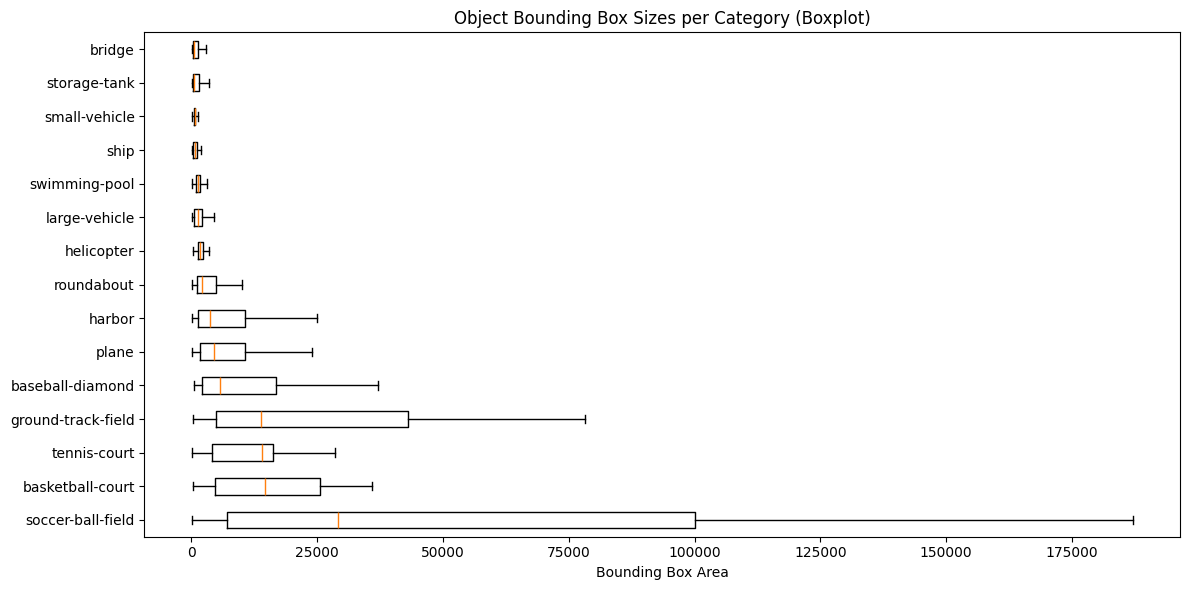

In [13]:
# Plotting
plt.figure(figsize=(12, 6))
sorted_categories = df_area.groupby("Category")["Area"].median().sort_values(ascending=False).index
df_area_sorted = df_area.copy()
df_area_sorted["Category"] = pd.Categorical(df_area_sorted["Category"], categories=sorted_categories)

plt.boxplot(
    [df_area_sorted[df_area_sorted["Category"] == cat]["Area"] for cat in sorted_categories],
    tick_labels=sorted_categories,
    showfliers=False,
    vert=False
)

# Add text labels to bars
plt.xlabel("Bounding Box Area")
plt.title("Object Bounding Box Sizes per Category (Boxplot)")
plt.tight_layout()
plt.show()

# 4 Modelling

# 4.1 DOTA dataset

In [14]:
class DotaRawDataset(Dataset):
    """
    Loading DOTA PyTorch Dataset
    """

    def __init__(
            self,
            image_dir,
            label_dir,
            transform=None,
            joint_transform=None,
    ):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.joint_transform = joint_transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.tif'))]
        self.image_files.sort()
        print("found images: {}".format(len(self.image_files)))

    def __len__(self):
        return len(self.image_files)

    def _parse_label_file(self, label_path):
        bboxes = []
        classes = []
        with open(label_path, 'r') as f:
            lines = f.readlines()[2:]
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 9:
                    continue
                points = list(map(float, parts[:8]))
                cls = parts[8]
                bbox = [(points[i], points[i + 1]) for i in range(0, 8, 2)]
                bboxes.append(bbox)
                classes.append(cls)
        return bboxes, classes

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.split('.')[0] + '.txt')
        img_bgr = cv2.imread(image_path)
        if os.path.exists(label_path):
            bboxes, classes = self._parse_label_file(label_path)
        else:
            bboxes, classes = [], []
        return img_bgr, {'boxes': bboxes, 'labels': classes}

train_dataset = DotaRawDataset(
    image_dir=os.path.join(DATASET_ROOT_DIR, 'val', 'images'),
    label_dir=os.path.join(DATASET_ROOT_DIR, 'val', 'labelTxt')
)
val_dataset = DotaRawDataset(
    image_dir=os.path.join(DATASET_ROOT_DIR, 'val', 'images'),
    label_dir=os.path.join(DATASET_ROOT_DIR, 'val', 'labelTxt')
)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/VisualDota/DOTA/val/images'

# 4.2 You Only Look Once Model (YOLO V11)

### 4.2.1 Define Model

In [ ]:
yolov11 = detector.YoloV11Detector(device=device)

### 4.2.2 Model Evaluation

In [ ]:
val_simple_dir = os.path.join(DATASET_ROOT_DIR, 'val')
yolov11_simple_result = yolov11.batch_visual_search(
    img_dir=os.path.join(val_simple_dir, 'images'),
    result_dir=os.path.join(val_simple_dir, 'base_pred'))

val_complex_dir = os.path.join(DATASET_ROOT_DIR, 'val_complex')
yolov11_complex_result = yolov11.batch_visual_search(
    img_dir=os.path.join(val_complex_dir, 'images'),
    result_dir=os.path.join(val_complex_dir, 'base_pred'))

# 4.2 MARS Agent

### 4.2.1 Model Training

In [ ]:
episodes = 10
log_interval = 5
MAX_NUM_EXPLORING_STEP = 20
rl_qtable_model = rl_model.RLQtableModel(save=True, load=True)


# data for performance figures
total_train_rewards = []
total_train_vehicles_found = []
total_train_avg_episode_steps = []

total_val_rewards = []
total_val_vehicles_found = []
total_val_avg_episode_steps = []

mars_agent = agent.MARSAgent(rl_model=rl_qtable_model, device=device)

for episode in range(episodes):
    episode_train_vehicles_found = 0
    episode_train_reward = 0
    episode_train_steps = 0
    count = 0
    start = time.time()
    for image, target in train_dataset:
        if image is None:
            print('empty image at count: {}'.format(count))
            continue
        count += 1
        step, image_reward, obbs = mars_agent.visual_search(image, target, max_step=MAX_NUM_EXPLORING_STEP, learn=True)
        # record this round
        episode_train_steps += step
        episode_train_reward += image_reward
        episode_train_vehicles_found += len(obbs)
        print(f'\rprocessed {count + 1} images.', end='', flush=True)
    total_train_rewards.append(episode_train_reward / count)
    total_train_vehicles_found.append(episode_train_vehicles_found / count)
    total_train_avg_episode_steps.append(episode_train_steps / count)

    # Valuate
    episode_val_vehicles_found = 0
    episode_val_reward = 0
    episode_val_steps = 0
    start = time.time()
    count = 0
    for image, target in val_dataset:
        if image is None:
            print('empty val image at count: {}'.format(count))
            continue
        count += 1
        step, image_reward, obbs = mars_agent.visual_search(image, target, max_step=MAX_NUM_EXPLORING_STEP, learn=True)
        # record this round
        episode_val_steps += step
        episode_val_reward += image_reward
        episode_val_vehicles_found += len(obbs)
        print(f'\rprocessed {count + 1} images.', end='', flush=True)
    total_val_rewards.append(episode_val_reward / count)
    total_val_vehicles_found.append(episode_val_vehicles_found / count)
    total_val_avg_episode_steps.append(episode_val_steps / count)

    # Print logs regularly
    print(f"Episode {episode:4d}/{episodes} | "
          f"Reward: {episode_train_reward:6.1f} | "
          f"Vehicles Found: {episode_train_vehicles_found:2d} | "
          f"Steps: {episode_train_steps}")
    rl_qtable_model.save('qtable-{}.pkl'.format(episode))



In [ ]:
# Draw a chart after training
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(total_train_vehicles_found, label='Train', alpha=0.3)
plt.plot(total_val_vehicles_found, label='Val', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Vehicles Found')
plt.title('Performance: Average Vehicles Found by Episode')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(total_train_rewards, label='Train', alpha=0.3)
plt.plot(total_val_rewards, label='Val', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Performance: Average Reward by Episode')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(total_train_avg_episode_steps, label='Train', alpha=0.3)
plt.plot(total_val_avg_episode_steps, label='Val', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average Steps')
plt.title('Performance: Average Steps by Episode')
plt.legend()
plt.grid(True)
total_avg_train_vehicle_found = [v/s for v, s in zip(total_train_vehicles_found, total_train_avg_episode_steps)]
total_avg_val_vehicle_found = [v/s for v, s in zip(total_val_vehicles_found, total_val_avg_episode_steps)]
plt.subplot(2, 2, 4)
plt.plot(total_avg_train_vehicle_found, label='Train', alpha=0.3)
plt.plot(total_avg_val_vehicle_found, label='Val', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Vehicle Found per Steps')
plt.title('Performance: Average Vehicle Found per Step by Episode')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

### 4.2.2 Evaluation

In [ ]:
mars_simple_results = mars_agent.batch_visual_search(
    img_dir=os.path.join(val_simple_dir, 'images'),
    result_dir=os.path.join(val_simple_dir, 'agent_pred'))

mars_complex_results = mars_agent.batch_visual_search(
    img_dir=os.path.join(val_complex_dir, 'images'),
    result_dir=os.path.join(val_complex_dir, 'agent_pred'))

# 5 Evaluation
## 5.1 Performance Measures

Evaluation Metrics, mAP (mean Average Precision) is used to evaluate the performance of both MARS agent and base model (YOLO v11) models.
Mars has slightly improved in mAP performance than the BASE model.

### 5.1.1 Simple datasets

In [ ]:
data_validation.run_dota_evaluation(label_dir=val_simple_dir)

### 5.1.2 Complex Images

In [ ]:
data_validation.run_dota_evaluation(label_dir=val_complex_dir)

In [ ]:
import app_v1
app_v1.demo.launch()

# Summary